# Tìm hiểu bộ dữ liệu Fashion-MNIST, xây dựng chương trình dùng giải thuật CNN(Convolutional Neural Network) phân loại dữ liệu cho bộ dữ liệu này

### Import và cài đặt các thư viện cần thiết để sử build model

In [4]:
#%pip install scikeras
#%pip install keras-tuner

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import savefig
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras_tuner.tuners import RandomSearch
from collections import Counter
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import MaxPooling2D, AveragePooling2D
from sklearn.metrics import accuracy_score



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [6]:
fashion_set = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
(X_train, y_train), (X_test, y_test) = fashion_set

#### Xem hình ảnh thông qua pyplot

In [8]:
def plot_image(X, y, images_per_row=10, name=''):
    size = 28 #default size X_train.shape
    number_img = X.shape[0]
    X = X.reshape(number_img, size, size)
    no_rows = int(np.ceil(number_img/images_per_row))
    n_empty_image = no_rows * images_per_row - number_img

    #combine input with empty set
    image_set = np.concatenate([X, np.zeros((n_empty_image, size, size))], axis=0)
    label_set = np.concatenate([y, -np.ones(n_empty_image)], axis=0)
    #image_grid = image_set.reshape(no_rows, images_per_row, size, size)
    #images = image_grid.transpose(0,2,1,3).reshape(no_rows * size, images_per_row * size)
    print(image_set.shape)
    #plt.imshow(X=images, , cmap=mpl.cm.binary)
    fig, axes = plt.subplots(nrows=no_rows, ncols=images_per_row, figsize=(images_per_row * 1.5,no_rows))
    fig.tight_layout(pad=0.13, rect=[0, 0.12, 1, 2]) #[left,bottom, right, top]

    for (i,ax), y_set in zip(enumerate(axes.flat), label_set):
        ax.imshow(image_set[i], cmap='binary')
        ax.set_title(f'{y_set}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(name, x=0.5, y=2.25)


(6, 28, 28)


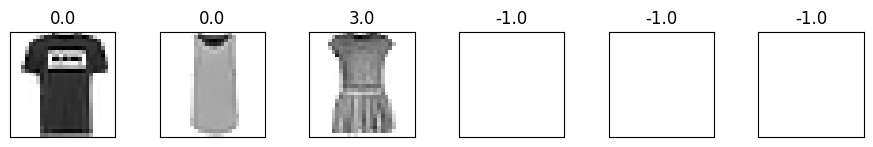

In [9]:
plot_image(X_train[1:4], y_train[1:4], images_per_row=6)

#### Thống kê data

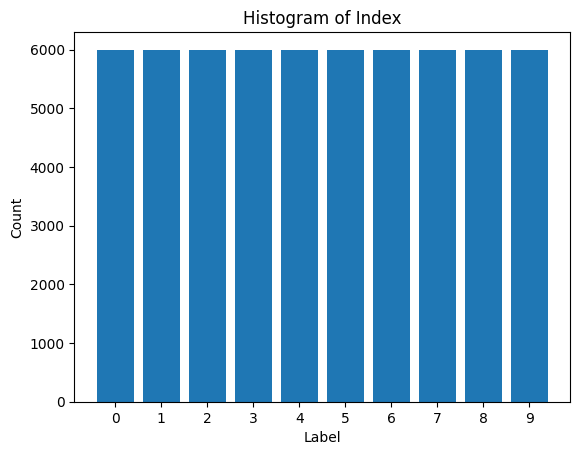

In [10]:

y_counter = Counter(y_train)
df = pd.DataFrame.from_dict(y_counter, orient='index', columns=['Count']).sort_index(ascending=True)
indexs = df.index
count_n = df['Count']
plt.bar(indexs, count_n, align='center')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Index')
plt.xticks(indexs)
savefig('distribution of label.png')
plt.show()

Dựa vào diagram ở trên có thể thấy số lượng tập train là đồng đều không bị mất cân bằng về các label

### Preprocess Data

Để thuận tiện cho việc tính toán ta cần xử lý data. Thấy rằng giá trị của các tập X đều nằm trong khoảng từ 0 - 255, vì thế ta có thể normalize các giá trị của các tập dữ liệu để dễ dàng tính toán

In [11]:
print(f'giá trị nhỏ nhất: {np.min(X_train)}')
print(f'giá trị lớn nhất: {np.max(X_train)}')

giá trị nhỏ nhất: 0
giá trị lớn nhất: 255


Và vì dùng giải thuật CNN nên phải reshape các tập dữ liệu đầu vào, biết rằng các tập dữ liệu có shape (<b>m</b>, 28, 28) và cần đưa về shape (<b>m</b>, 28, 28, 1)

<b>m</b>: số lượng đầu vào input(ở tập X_train là 60000, ở tập X_test: 10000)

In [12]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_test: {X_test.shape}')

Shape X_train: (60000, 28, 28)
Shape X_test: (10000, 28, 28)


Vì cần xử lí 2 vấn đề ở trên nên tiến hành tạo 1 pipeline cho phép xử lý data:

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_process = X/255
        return X_process.reshape(X.shape[0], 28, 28, 1)

In [14]:
processor = Pipeline([
    ('Process', Preprocessor())
])

In [15]:
#Split Data from train set to train and cross set
from sklearn.model_selection import train_test_split
X_train_, X_cross_, y_train_,  y_cross = train_test_split(X_train, y_train, random_state=42, train_size=0.8, stratify=y_train)

In [17]:
X_train_process = processor.fit_transform(X_train_)
X_cross_process = processor.transform(X_cross_)

### Build Model

### Implement thuần CNN

Note: layer ngoài cùng được set là <b>linear</b> thay vì <b>softmax</b> là để phục vụ cho việc tính hàm loss trở nên chính xác hơn.

In [16]:
#input shape(28, 28)

model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)),
    Conv2D(16, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))

In [19]:
history = model.fit(X_train_process, y_train_, verbose=1, epochs=20, validation_data=(X_cross_process, y_cross))

Epoch 1/20
1500/1500 [==============================] - 17s 4ms/step - loss: 0.4552 - accuracy: 0.8344 - val_loss: 0.3670 - val_accuracy: 0.8684
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2974 - accuracy: 0.8889 - val_loss: 0.2802 - val_accuracy: 0.8982
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2431 - accuracy: 0.9100 - val_loss: 0.2680 - val_accuracy: 0.9033
Epoch 4/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2031 - accuracy: 0.9223 - val_loss: 0.2670 - val_accuracy: 0.9070
Epoch 5/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1629 - accuracy: 0.9388 - val_loss: 0.2680 - val_accuracy: 0.9124
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1335 - accuracy: 0.9489 - val_loss: 0.2838 - val_accuracy: 0.9110
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1037 - accuracy: 0.9616 - val_loss: 0.3071 - val_accuracy

In [20]:
X_test_process = processor.transform(X_test)
y_pred = np.argmax(model.predict(X_test_process), axis=1)
#print(X_test_process.shape, y_pred.shape)
print(accuracy_score(y_test, y_pred))

313/313 [==============================] - 1s 2ms/step
0.9052


### Nhận xét khi Implement thuần

In [21]:
history_frame = pd.DataFrame(history.history)

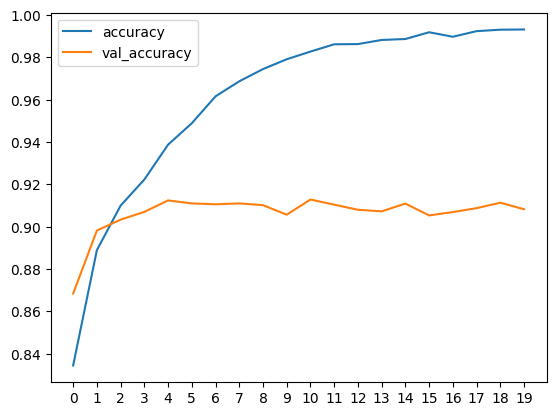

In [22]:
history_frame[['accuracy', 'val_accuracy']].plot()
k = plt.xticks(history_frame.index)
savefig('acc_vs_cv_acc_before_tuning_model.png')

In [23]:
model.save('model_cnn.h5')

Mặc dù độ chính xác của tập test khá cao nhưng có thể nhận thấy trên biểu đồ, validation_accuracy có độ lệch khá cao so với accuracy => (High Variance Problem)

### Build Model bằng cách sử dụng Random Search và sử dụng ImageGenerator để có được nhiều data training hơn (Data Augment)

#### Lấy thêm dữ liệu (Data Augment)

Sử dụng phương pháp augement data để có thể tạo thêm nhiều dữ liệu cho tập train

In [24]:
from keras.preprocessing.image import ImageDataGenerator


Sinh data theo các phương pháp:
* RandomFlip
* RandomRotation
* Shifting
* Zoom

In [25]:
data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='nearest', cval=0)

In [26]:
data_generator.fit(X_train_process)

In [27]:
batch = data_generator.flow(X_train_process, y_train_, seed=42, batch_size=128)
batch.image_data_generator

In [28]:
X_batch, y_batch = data_generator.flow(X_train_process, y_train_, batch_size=10, shuffle=False).next()

(10, 28, 28)
(10, 28, 28)


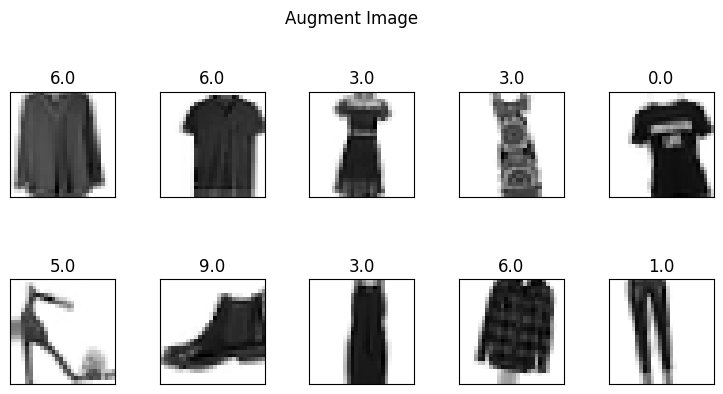

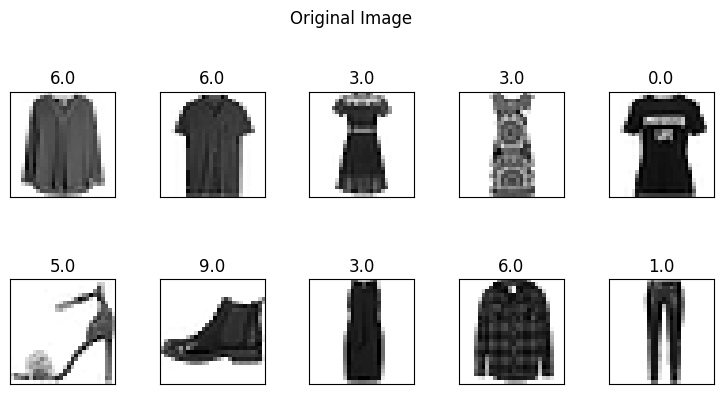

In [29]:
plot_image(X_batch[:10], y_batch[:10], 5, 'Augment Image')
plot_image(X_train_process[:10], y_batch[:10], 5, 'Original Image')

####

In [30]:
X_augment, y_augment = data_generator.flow(X_train_process, y_train_, batch_size=X_train_process.size).next()

In [31]:
X_augment_train = np.concatenate((X_augment, X_train_process), axis=0)
y_augment_train = np.concatenate((y_augment, y_train_), axis=0)
print(y_augment_train.shape)
shuffle_indices = np.random.permutation(X_augment_train.shape[0])
X_augment_train = X_augment_train[shuffle_indices]
y_augment_train = y_augment_train[shuffle_indices]

(96000,)


In [98]:
#plot_image(X_augment_train[:10], y_augment_train[:10])

#### Build Model with Random Search

Random Search là một phương pháp tối ưu hóa hyperparameter được sử dụng để tìm ra kết hợp các hyperparameter tốt nhất cho model. Phương pháp này rất đơn giản, chỉ cần lặp lại các thử nghiệm với các kết hợp hyperparameter khác nhau một cách ngẫu nhiên.

In [99]:
#early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, restore_best_weights=True)

create_model: tạo 1 model với tham số là hyperparameter
> ở đây ta có thể set ngẫu nhiên các hyperparam như sau
> * Tạo ngẫu nhiên Pool (MaxPooling hoặc AveragePooling)
> * Tạo 1 lớp Conv2D có số units ngẫu nhiên từ 32 đến 64
> * Tạo từ 2 đến 3 lớp Dense có số units ngẫu nhiên từ 64 đến 512 với step = 32
> * Chọn activation (relu hoặc softmax)
> * sử dụng kernel_regularizer l2regularizer để giảm overfitting có alpha từ 0.01 đến 0.001
> * sử dụng Dropout(drop_chance=0.25) để giảm overfitting
> * sử dụng Adam Optimizer với learning_rate khoảng từ 0.01 đến 0.0001

In [34]:
def create_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))

    pool_type = hp.Choice('pool_type', ['max', 'average'])

    if pool_type=='max':
        model.add(MaxPooling2D(pool_size=(2,2)))
    elif pool_type=='average':
        model.add(AveragePooling2D(pool_size=(2,2)))

    model.add(
        Conv2D(hp.Int('conv2d_layers',32,64), (3,3), activation='relu')
    )

    model.add(Flatten())

    for i in range(hp.Int('dense_layers', 2, 3)):
      model.add(Dense(
          hp.Int(f'no_layers_{i}', min_value=64, max_value=512,step=32),
          activation=hp.Choice(f'activation_{i}', ['relu','softmax']),
          kernel_regularizer=regularizers.l2((hp.Float(f'kernel_reg_{i}', min_value=1e-3, max_value=1e-2))
      )))
      if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))

    model.add(Dense(10, activation='linear'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))
    return model

Tạo 1 Random Search với các tham số:
* hyper_model : model để đưa các hyperparam
* objective: hướng tối ưu, dựa vào độ chính xác val_accuracy để xác định model nào trong random_search là tốt nhất
* max_trials: tạo tổ hợp hyperparam ngẫu nhiên 5 lần
* execution_per_trials: mỗi 1 tổ hợp hyperparam thì tạo ra bao nhiêu model. (Vì mỗi lần tạo 1 model là các weights của model này là khác nhau)
* directory: thư mực chứa các model được build
* project_name: thư mực con của directory chứa các model
* seed: <a href='https://news.mit.edu/2019/answer-life-universe-and-everything-sum-three-cubes-mathematics-0910#:~:text=The%20number%2042%20is%20especially,the%20Universe%2C%20and%20Everything.%E2%80%9D'>42</a>

In [35]:
model_rs = RandomSearch(create_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=2,
                        directory='model_random_stored',
                        project_name='model_training', seed=42)


In [36]:
model_rs.search_space_summary() #các thông sau hyperparam 

Search space summary
Default search space size: 11
pool_type (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'average'], 'ordered': False}
conv2d_layers (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
no_layers_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax'], 'ordered': False}
kernel_reg_0 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
no_layers_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [],

In [37]:
model_rs.search(X_augment_train, y_augment_train, epochs=20, validation_data=(X_cross_process, y_cross))

Trial 5 Complete [00h 08m 37s]
val_accuracy: 0.8920833170413971

Best val_accuracy So Far: 0.9087083339691162
Total elapsed time: 00h 46m 51s


In [42]:
model_rs.results_summary() # liệt kê các model có hyperparam có val_accuracy cao nhất

Results summary
Results in model_random_stored/model_training
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
pool_type: max
conv2d_layers: 44
dense_layers: 3
no_layers_0: 448
activation_0: relu
kernel_reg_0: 0.0034434200193395104
dropout: True
no_layers_1: 128
activation_1: relu
kernel_reg_1: 0.0075837801736019
lr: 0.00025071332274895686
no_layers_2: 64
activation_2: relu
kernel_reg_2: 0.001
Score: 0.9087083339691162

Trial 1 summary
Hyperparameters:
pool_type: average
conv2d_layers: 62
dense_layers: 2
no_layers_0: 512
activation_0: relu
kernel_reg_0: 0.006226814484405611
dropout: False
no_layers_1: 192
activation_1: relu
kernel_reg_1: 0.009351924092899068
lr: 0.0007767449713530701
Score: 0.9026666581630707

Trial 4 summary
Hyperparameters:
pool_type: average
conv2d_layers: 36
dense_layers: 2
no_layers_0: 96
activation_0: relu
kernel_reg_0: 0.0017516846903822712
dropout: False
no_layers_1: 480
activation_1: softmax
kernel_reg_1:

In [78]:
best_model = model_rs.get_best_models(1)[-1]


In [105]:
best_model.history.history

{}

In [79]:
y_pred_reg = np.argmax(best_model.predict(X_test_process), axis=1)
accuracy_score(y_test, y_pred_reg)
#y_pred_reg

313/313 [==============================] - 1s 2ms/step


0.9008

In [80]:
best_model.save('model_using_random_search.h5')

### Transfer Learning

In [ ]:
#%pip install tensorflow_hub

Transfer learning là một kỹ thuật học máy sử dụng kiến thức thu được từ một tác vụ (tác vụ nguồn) để giải quyết một tác vụ khác nhưng tương tự (tác vụ đích).

Trong transfer learning, chúng ta sẽ sử dụng một mô hình đã được đào tạo trước trên một tập dữ liệu lớn cho tác vụ nguồn. Sau đó, chúng ta sẽ tinh chỉnh mô hình này cho tác vụ đích bằng cách chỉ đào tạo các lớp trên cùng của mô hình. (Ở đây sẽ dùng ResNet50)

Vì yêu cầu đầu vào của ResNet50 cần có channel=3 (chiều thứ 3 của 1 hình ảnh r,g,b nhưng hình ảnh của MNIST Fashion chỉ là hình ảnh gray_scale nên tiến hành tạo thêm 3 lớp)

In [81]:
def expand_gray_scale(X):
    X_3_channel = X.repeat(3, axis=-1) #expand to 3 dimension
    return X_3_channel

In [82]:
X_augment_train_3 = expand_gray_scale(X_augment_train)
X_cross_3 = expand_gray_scale(X_cross_process)
X_test_3 = expand_gray_scale(X_test_process)

In [83]:
X_augment_train_3.shape

(96000, 28, 28, 3)

In [93]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False,pooling='avg', weights='imagenet'))

transfer_model.add(Dense(512,activation='relu'))
transfer_model.add(Dense(10, activation='linear'))

transfer_model.layers[0].trainable=False #Chúng ta không train phần đã có sẵn
transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))


In [94]:
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [95]:
transfer_model.fit(X_augment_train_3, y_augment_train,epochs=20,verbose=1, validation_data=(X_cross_3, y_cross))

Epoch 1/20
3000/3000 [==============================] - 38s 11ms/step - loss: 0.8910 - accuracy: 0.6612 - val_loss: 0.6385 - val_accuracy: 0.7499
Epoch 2/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.7405 - accuracy: 0.7135 - val_loss: 0.6070 - val_accuracy: 0.7687
Epoch 3/20
3000/3000 [==============================] - 32s 11ms/step - loss: 0.7053 - accuracy: 0.7257 - val_loss: 0.5808 - val_accuracy: 0.7725
Epoch 4/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.6767 - accuracy: 0.7386 - val_loss: 0.5653 - val_accuracy: 0.7862
Epoch 5/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.6597 - accuracy: 0.7435 - val_loss: 0.5657 - val_accuracy: 0.7827
Epoch 6/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.6475 - accuracy: 0.7476 - val_loss: 0.5353 - val_accuracy: 0.7983
Epoch 7/20
3000/3000 [==============================] - 33s 11ms/step - loss: 0.6344 - accuracy: 0.7556 - val_loss: 0.5494 -

Preprocess Data

In [96]:
y_pred_reg = np.argmax(transfer_model.predict(X_test_3), axis=1)
accuracy_score(y_test, y_pred_reg)
#y_pred_reg

313/313 [==============================] - 4s 9ms/step


0.8034

In [97]:
transfer_model.save('transfer_model.h5')